# WAMIDA Statistical Analysis


This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables. Categorical variables are changed into dummy variables for binary categories.

**2. Exploratory Data Analysis**

We can conduct a Mann-Whitney U test for continuous data and Fisher exact test for binary data. We can also compute Pearson correlation coefficients as well. Note that the p-values are not representative of how significant a logistic fit is (this is what we really want in the end), but this can allow us to be exploratory to see which variables are very viable or very unviable for logistic regression fit.

**3. Logistic Regression, Refactoring Low Significance Variables and Re-fitting**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported along with P-value The high-p variables are removed and then logistic regression is re-fitted to achieve a higher accruacy fit. Odds ratios can then be reported.

# 1. Preprocessing

In [26]:
# Setup, imports
import math
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu
import scipy.stats as stats
from tableone import TableOne

matplotlib.rcParams['figure.figsize'] = [40, 20]

In [24]:
data = pd.read_excel('input.xlsx')
#Age has a space afterward in the spreadsheet,
data = data.drop(columns = ['Study ID'])
cols_num = ['Age ', 'Pack Years', 'Drinks/Week', 'BMI', 'SF-12', 'Cardiac Anxiety', 'MOS Score']
data_num = data[cols_num]
data_cat = data.drop(columns = cols_num)

,Age,Ethnicity,Sex,Education Level,Employment,Income (2019),Married?,Pack Years,Drinks/Week,Hx Substance Use Disorder,...,New Depression,New Anxiety,Deceased,CV Event,Cardiac Rehab,HADS-D F/U,HADS-A F/U,SF-12,Cardiac Anxiety,MOS Score
0,78,0,0,0,0,0.0,0,17.0,0,1,...,1.0,1.0,1,1,1.0,0.0,0.0,26.0,22.0,38.0
1,67,0,1,0,1,1.0,0,26.0,10,1,...,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,80,0,1,1,1,1.0,1,30.0,25,1,...,1.0,1.0,1,0,1.0,1.0,1.0,31.0,3.0,95.0
3,56,0,1,1,1,1.0,0,40.0,0,1,...,1.0,1.0,1,1,1.0,0.0,1.0,30.0,14.0,29.0
4,58,0,0,1,1,1.0,1,40.0,0,1,...,1.0,1.0,1,1,1.0,1.0,1.0,31.0,21.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,49,0,1,1,0,1.0,1,30.0,0,1,...,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
114,70,0,1,1,1,1.0,1,15.0,7,1,...,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
115,65,0,1,0,1,1.0,1,35.0,0,0,...,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
116,73,0,0,1,1,1.0,1,0.0,0,1,...,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#defining columns to include
columns = list(data)
categorical = list(data_cat)


C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
table1hadsD = TableOne(data, columns=columns, categorical=categorical, pval = True, groupby ='HADS D', smd=True,
                  htest_name=True)
table1hadsA = TableOne(data, columns=columns, categorical=categorical, pval = True, groupby ='HADS A', smd=True,
                  htest_name=True)

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory Data Analysis

## Testing Colinearity with Variance Inflation Factor, colinear variables would not be of statistical value and would be removed for a regression fit 


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = data.iloc[:,:-13].dropna()
calc_vif(X)


,variables,VIF
0,Age,29.945198
1,Ethnicity,1.193055
2,Sex,4.313584
3,Education Level,2.259804
4,Employment,15.426156
5,Income (2019),12.318010
6,Married?,3.628177
7,Pack Years,2.605604
8,Drinks/Week,1.403264
9,Hx Substance Use Disorder,26.446034


## Before the first exlusion of features, for instance, BMI was colinear with height and weight. Any collinear variables should be excluded. At this point, all VIF is < 10, which means low collinearity, although some papers argue whether the threshold should be 10 or 5 etc.

## We can visualize pearson correlation of the with a correlation matrix 

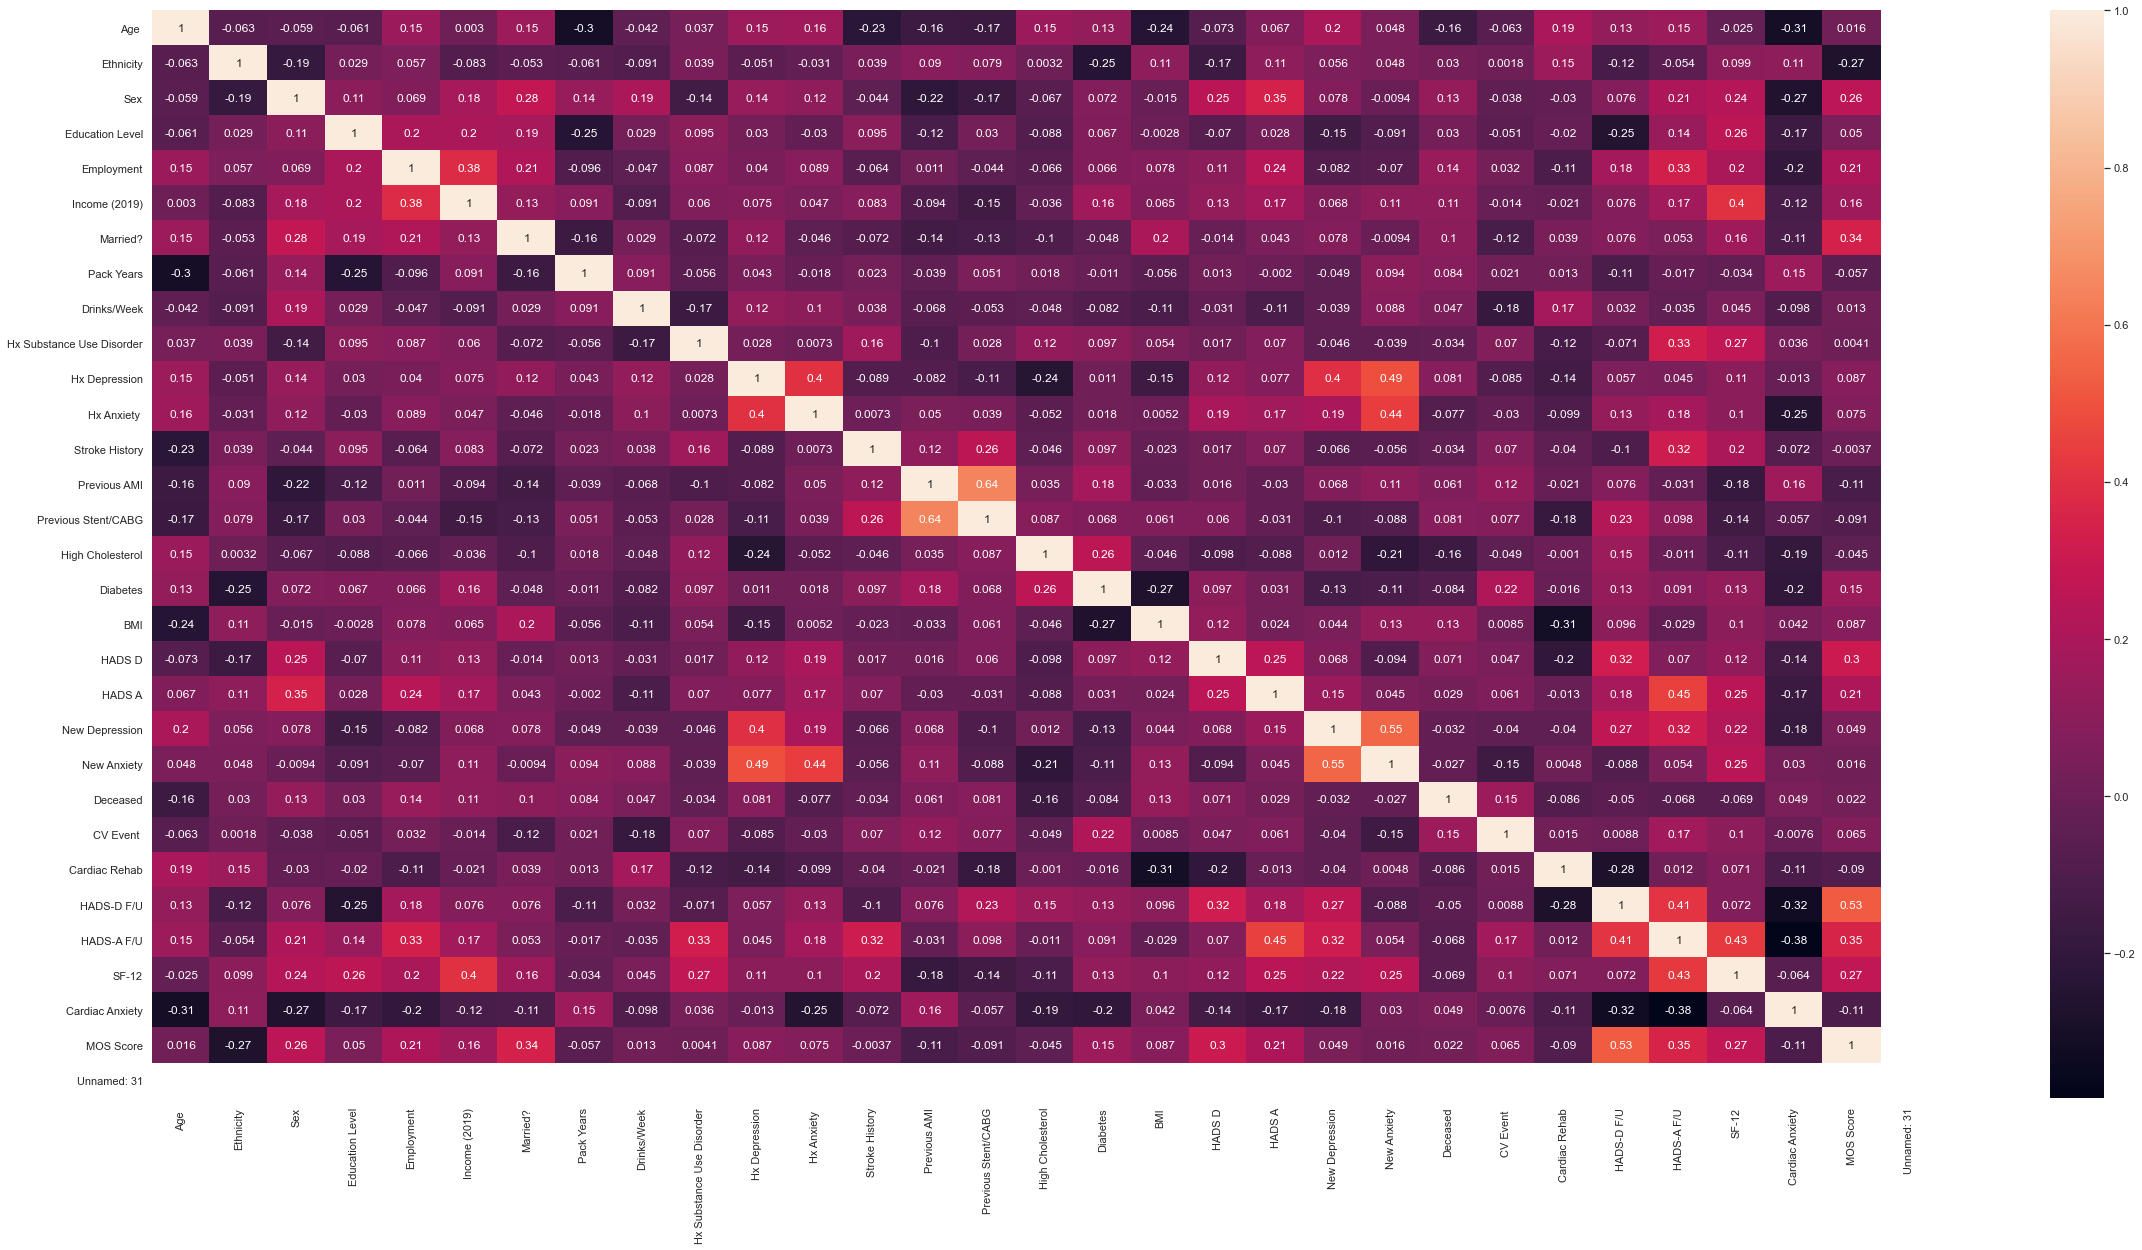

In [21]:
corrMatrix = data.corr()
fig = sn.heatmap(corrMatrix, annot=True)
plt.show()

In [22]:
corrMatrix

,Age,Ethnicity,Sex,Education Level,Employment,Income (2019),Married?,Pack Years,Drinks/Week,Hx Substance Use Disorder,...,New Anxiety,Deceased,CV Event,Cardiac Rehab,HADS-D F/U,HADS-A F/U,SF-12,Cardiac Anxiety,MOS Score,Unnamed: 31
Age,1.000000,-0.063422,-0.058957,-0.060889,0.147640,0.003039,0.151485,-0.303808,-0.042420,0.036525,...,0.047748,-0.162384,-0.062692,0.190277,0.129012,0.153315,-0.025393,-0.307185,0.016147,NaN
Ethnicity,-0.063422,1.000000,-0.185934,0.028912,0.056999,-0.083149,-0.052776,-0.061093,-0.091375,0.039402,...,0.048387,0.030254,0.001823,0.151967,-0.124111,-0.053548,0.099268,0.111783,-0.274229,NaN
Sex,-0.058957,-0.185934,1.000000,0.106276,0.068877,0.184787,0.279337,0.137432,0.194580,-0.136597,...,-0.009437,0.130855,-0.038276,-0.029637,0.075958,0.205598,0.235514,-0.265111,0.255682,NaN
Education Level,-0.060889,0.028912,0.106276,1.000000,0.199348,0.195471,0.186027,-0.245747,0.029088,0.095238,...,-0.090513,0.029546,-0.050734,-0.020305,-0.254309,0.140859,0.261304,-0.165010,0.050329,NaN
Employment,0.147640,0.056999,0.068877,0.199348,1.000000,0.378295,0.212187,-0.095565,-0.046758,0.087051,...,-0.070148,0.144165,0.031980,-0.106658,0.179927,0.329926,0.204891,-0.198022,0.206435,NaN
Income (2019),0.003039,-0.083149,0.184787,0.195471,0.378295,1.000000,0.125353,0.090843,-0.090940,0.059761,...,0.109428,0.114708,-0.013997,-0.021041,0.075974,0.171270,0.401160,-0.116375,0.159965,NaN
Married?,0.151485,-0.052776,0.279337,0.186027,0.212187,0.125353,1.000000,-0.164387,0.028986,-0.071859,...,-0.009437,0.101440,-0.118579,0.039163,0.075958,0.052868,0.158732,-0.109586,0.342454,NaN
Pack Years,-0.303808,-0.061093,0.137432,-0.245747,-0.095565,0.090843,-0.164387,1.000000,0.091491,-0.056209,...,0.094206,0.083502,0.021256,0.013226,-0.112721,-0.016747,-0.033817,0.151800,-0.056594,NaN
Drinks/Week,-0.042420,-0.091375,0.194580,0.029088,-0.046758,-0.090940,0.028986,0.091491,1.000000,-0.167258,...,0.088455,0.046555,-0.179609,0.172887,0.031500,-0.035443,0.044545,-0.097653,0.013185,NaN
Hx Substance Use Disorder,0.036525,0.039402,-0.136597,0.095238,0.087051,0.059761,-0.071859,-0.056209,-0.167258,1.000000,...,-0.039193,-0.033975,0.070416,-0.123091,-0.071429,0.325300,0.273927,0.035775,0.004107,NaN


## It is interesting to visually inspect correlations of variables with each other depending on the dataset (e.g. if a complex variable like entropy is used then we want to observe its relationship to other abstracted variables), though our main interest is to compute the correlation ratio and its p-value to the outcome of each variable, which we do below:

In [25]:
corrDataHADSA = []
corrDataHADSD = []


for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['HADS A'])
    corrDataHADSA.append([cols, r, p])

for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['HADS D'])
    corrDataHADSD.append([cols, r, p])


pd.set_option('display.max_rows', None)

corrDFHADSA = pd.DataFrame(corrDataHADSA, columns = ['Var', 'r','p'])
corrDFHADSD = pd.DataFrame(corrDataHADSD, columns = ['Var', 'r','p'])


print("\n HADS A: \n", corrDFHADSA)
print("\n HADS D: \n", corrDFHADSD)

ValueError: array must not contain infs or NaNs

## As a preliminary analysis, we can see there are some variables that show some correlation, but the correlation and significance is weak for the most part. This may suggestion that the relationship between the variables to the outcome is nonlinear and linear correlation analysis is insufficient.


# Independent p-values

## We can do some biostat faves and look at MWU values for continuous (comparing to HADS A and HADS D, quasi-continuous, really, since it's all integer data) and Fisher values (comparing to 0/1 of depression or no depression) for binary data. 

## The value of this is that the p-values tell us if the distributions of variables between positive vs. negative outcome has *some significant difference*. This is still valuable to report though there are two mathematical caveats to keep in mind:

1. The p-values look at variables independently. If the relationship can be sufficiently analyzed by linear correlation analysis, then this is great. If the variables are dependent on each other, then there is a chance the traditional p-value may come to a false conclusion. For instance, if pack years is a random predictor by itself but is a strong positive predictor only when drinks/week is within some range, then the p-value would false report that pack years is not significant differently distributed between the outcomes.

2. A p<0.05 (the traditional threshold) tells us the two distributions (e.g. pack years for positive depression vs. pack years for negative depression) has *some significant difference*. This is great for observational statistics ("this variable is important to look at") but requires more work for inferential statistics ("we can use this variable by this weighing formula to predict the outcome") because it doesn't tell us the mathematical nature of the relationship between variables and outcome. Hence, the we can utilize the p-value in two ways: to state that a variable may be significant from an initial linear, independent view and to use as a first-pass filtering of variables if we don't have enough samples to build a model.

# Wilcoxon (Mann-Whitney variant) Test for Continuous Data

## For the variables that are unpaired, continuous, and non-Gaussian (theoretically it should be Gaussian by central limit theorem, but likely not enough samples), the Wilcoxon Mann-Whitney test was chosen and computed below (can't do Wilcoxon because variables are different length)

In [36]:
data_num.columns

Index(['Age ', 'Pack Years', 'Drinks/Week', 'BMI'], dtype='object')

In [37]:
# extraction variable values for positive and negative outcomes

MWUResults = []
print('Mann-Whitney U test p values for continuous data, comparing distributions of variable values for positive vs. negative outcomes: \n')
for cols in data_num.columns:
    posOutcomeAnx = []
    negOutcomeAnx = []
    posOutcomeDep = []
    negOutcomeDep = []
    if ((cols != 'HADS A') and (cols != 'HADS D')):
        for row,val in data_num[cols].iteritems():
            variableVal = data_num[cols][row]
            if data_cat['HADS A'][row] == 0:
                negOutcomeAnx.append(variableVal)
            else:
                posOutcomeAnx.append(variableVal)
            if data_cat['HADS D'][row] == 0:
                negOutcomeDep.append(variableVal)
            else:
                posOutcomeDep.append(variableVal)
        uDep, pAnx = mannwhitneyu(negOutcomeAnx,posOutcomeAnx)
        uDep, pDep = mannwhitneyu(negOutcomeDep,posOutcomeDep)
    
        MWUResults.append([cols, pAnx, pDep])

MWUdf = pd.DataFrame(MWUResults, columns = ['cols', 'pAnx','pDep'])
print(MWUdf)

Mann-Whitney U test p values for continuous data, comparing distributions of variable values for positive vs. negative outcomes: 

          cols      pAnx      pDep
0         Age   0.434684  0.281373
1   Pack Years  0.126367  0.326955
2  Drinks/Week  0.369471  0.228401
3          BMI  0.103200  0.253908


P-values for continuous variables are quite bad. This is not to say the variables aren't significant, just that under the current dataset shows little linear independent significance. We can still use some data science techniques for predictabilitiy later on.

Perhaps because distributions of data are not Gaussian (they should be if we have enough samples under CLT) as that signifies not enough data has been collected to analyze these variables using techniques that rely on randomizations being balance under a Gaussian distribution (i.e. almost all p-value tests)

# For the binary variables, we use Fisher's Exact Test

## We have to create contingency tables for each variables with respect to the outcome (binary anxiety or binary depression outcomes), then compute the Fisher exact test odds ratio and p-value

In [38]:
print('Fisher exact test values: \n')

fisherResults =[ ]

for cols in data_cat.columns:
    data_crosstabAnx = pd.crosstab(data_cat[cols],data_cat['HADS A'])
    data_crosstabDep = pd.crosstab(data_cat[cols],data_cat['HADS D'])
    orAnx, pAnx = stats.fisher_exact(data_crosstabAnx)
    orDep, pDep = stats.fisher_exact(data_crosstabDep)

    fisherResults.append([cols, orAnx, pAnx, orDep, pDep])
    
fisherdf = pd.DataFrame(fisherResults, columns = ['cols', 'orAnx', 'pAnx','orDep','pDep'])
print(fisherdf)

Fisher exact test values: 

                               cols     orAnx          pAnx      orDep  \
0                         Ethnicity  0.000000  1.000000e+00  15.076923   
1                               Sex  7.012346  9.561092e-05   3.208791   
2                   Education Level  1.451247  4.970248e-01   0.618534   
3                        Employment  6.710526  7.220580e-03   3.285714   
4                     Income (2019)  5.305263  1.345192e-02   2.843750   
5                    Marital Status  1.131313  8.182480e-01   0.802632   
6                           Smoked   0.515298  1.972628e-01   0.929054   
7         Hx Substance Use Disorder  2.492754  3.014577e-01   0.000000   
8                     Hx Depression  1.604167  5.246124e-01   2.405594   
9                        Hx Anxiety  2.273504  1.404037e-01   2.800000   
10        More Anxious During COVID  2.314286  7.302528e-02   1.551020   
11  Time to Care Impacted by COVID?  6.589286  1.254227e-03   1.653846   
12        

## P-values are all over the place, especially for the binary variables likely due to low frequency and the algorithm thinks it's all due to chance, with the exception of a few variables (sex, Hx Anxiety maybe). Likely more samples are needed to elicit a meaningful Fisher test.

## We can also do a basic linear odds ratio calculation

In [39]:
print('Linear Odds Ratios: \n')

ORResults =[ ]

for cols in data_cat.columns:
    
    data_crosstabDep = pd.crosstab(data_cat[cols],data_cat['HADS D'])
    tpDep = data_crosstabDep.iloc[1][1]
    tnDep = data_crosstabDep.iloc[0][0]
    fpDep = data_crosstabDep.iloc[1][0]
    fnDep = data_crosstabDep.iloc[0][1]
    
    if(tpDep == 0 or tnDep == 0 or fpDep == 0 or fnDep == 0):
        tpDep = tpDep + 0.5
        tnDep = tnDep + 0.5
        fpDep = fpDep + 0.5
        fnDep = fnDep + 0.5
        
    linORDep = (tpDep*tnDep)/(fpDep*fnDep)
    SEDep = math.sqrt(1/tpDep + 1/tnDep + 1/fpDep + 1/fnDep)
    zDep = math.log(linORDep)/SEDep
    CILowDep = math.exp(math.log(linORDep) - 1.96*SEDep)
    CIHighDep = math.exp(math.log(linORDep) + 1.96*SEDep)
    pDep=stats.norm.sf(abs(zDep))*2 
    
    data_crosstabAnx = pd.crosstab(data_cat[cols],data_cat['HADS A'])
    tpAnx = data_crosstabAnx.iloc[1][1]
    tnAnx = data_crosstabAnx.iloc[0][0]
    fpAnx = data_crosstabAnx.iloc[1][0]
    fnAnx = data_crosstabAnx.iloc[0][1]    
    
    if(tpAnx == 0 or tnAnx == 0 or fpAnx == 0 or fnAnx == 0):
        tpAnx = tpAnx + 0.5
        tnAnx = tnAnx + 0.5
        fpAnx = fpAnx + 0.5
        fnAnx = fnAnx + 0.5
        
    linORAnx = (tpAnx*tnAnx)/(fpAnx*fnAnx)
    SEAnx = math.sqrt(1/tpAnx + 1/tnAnx + 1/fpAnx + 1/fnAnx)
    zAnx = math.log(linORAnx)/SEAnx
    CILowAnx = math.exp(math.log(linORAnx) - 1.96*SEAnx)
    CIHighAnx = math.exp(math.log(linORAnx) + 1.96*SEAnx)
    pAnx=stats.norm.sf(abs(zAnx))*2 
    
    ORResults.append([cols, linORDep, CILowDep, CIHighDep, pDep, 
                          linORAnx, CILowAnx, CIHighAnx, pAnx])
    
ORdf = pd.DataFrame(ORResults, columns = ['cols', 'linORDep', 'CILowDep', 'CIHighDep', 'pDep', 
                          'linORAnx', 'CILowAnx', 'CIHighAnx', 'pAnx'])
print(ORdf)

Linear Odds Ratios: 

                               cols     linORDep    CILowDep      CIHighDep  \
0                         Ethnicity    15.076923    1.276259     178.109318   
1                               Sex     3.208791    1.058784       9.724687   
2                   Education Level     0.618534    0.207882       1.840393   
3                        Employment     3.285714    0.747744      14.437979   
4                     Income (2019)     2.843750    0.662353      12.209369   
5                    Marital Status     0.802632    0.254802       2.528311   
6                           Smoked      0.929054    0.271300       3.181497   
7         Hx Substance Use Disorder     0.554252    0.029169      10.531594   
8                     Hx Depression     2.405594    0.665875       8.690651   
9                        Hx Anxiety     2.800000    0.838339       9.351823   
10        More Anxious During COVID     1.551020    0.521535       4.612659   
11  Time to Care Impacted by C

## 3. Initial Attempt at Logistic Regression

## First removing colinear variables, similar to above. Note that categorical variables are not defined for VIF, colinearity is not well understood for those

In [40]:
data_final = data.drop(columns=[])
data_final.columns

Index(['Age ', 'Ethnicity', 'Sex', 'Education Level', 'Employment',
       'Income (2019)', 'Marital Status', 'Smoked ',
       'Hx Substance Use Disorder', 'Hx Depression', 'Hx Anxiety',
       'More Anxious During COVID', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'HADS D', 'HADS A', 'Pack Years',
       'Drinks/Week', 'BMI'],
      dtype='object')

## Removing low-variance variables

In [41]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
X = data_final
min_variance = 0.1
high_var_cols = variance_threshold_selector(X, min_variance) 
print('columns remaining: ', high_var_cols.columns )
print(len(high_var_cols.columns))
X_low_var_removed = data_final[high_var_cols.columns]
X_low_var_removed.columns

columns remaining:  Index(['Age ', 'Sex', 'Education Level', 'Marital Status', 'Smoked ',
       'Hx Depression', 'Hx Anxiety', 'More Anxious During COVID',
       'Time to Care Impacted by COVID?', 'COVID Lonely?', 'Previous AMI',
       'Previous Stent/CABG', 'High Cholesterol', 'Diabetes', 'HADS D',
       'HADS A', 'Pack Years', 'Drinks/Week', 'BMI'],
      dtype='object')
19


Index(['Age ', 'Sex', 'Education Level', 'Marital Status', 'Smoked ',
       'Hx Depression', 'Hx Anxiety', 'More Anxious During COVID',
       'Time to Care Impacted by COVID?', 'COVID Lonely?', 'Previous AMI',
       'Previous Stent/CABG', 'High Cholesterol', 'Diabetes', 'HADS D',
       'HADS A', 'Pack Years', 'Drinks/Week', 'BMI'],
      dtype='object')

# Now that no remaining variables are colinear, we can begin regression

# For Anxiety:

In [59]:
import statsmodels.api as sm

# for Anxiety
y = data_final['HADS A']
X = data_final.drop(columns = ['HADS A', 'HADS D'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Index(['Age ', 'Ethnicity', 'Sex', 'Education Level', 'Employment',
       'Income (2019)', 'Marital Status', 'Smoked ',
       'Hx Substance Use Disorder', 'Hx Depression', 'Hx Anxiety',
       'More Anxious During COVID', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'Pack Years', 'Drinks/Week', 'BMI'],
      dtype='object')
         Current function value: 0.343172
         Iterations: 35
                                       Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.348    
Dependent Variable:           HADS A                    AIC:                       122.2431 
Date:                         2021-04-29 13:57          BIC:                       182.4395 
No. Observations:             114                       Log-Likelihood:            -39.122  
Df Model:                     21                        LL-Null:              

C:\Users\rckyh\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# Refactoring variables and repeating logistic regression fit

## P values are not very good, this is most likely due to undersampling (rule of thumb is 10x the number of variables needed as a sample size). What we can do is remove the very low statistical power variables and re-fit

In [61]:
low_sig_cols = ['Education Level', 'Income (2019)',
                'Marital Status', 'Smoked ', 'Pack Years','Drinks/Week',
               'Hx Depression','Stroke', 'Previous AMI', 'High Cholesterol',
               'Previous Stent/CABG', 'Ethnicity']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
resultAnx=logit_model.fit()
print(resultAnx.summary2())


Index(['Age ', 'Sex', 'Employment', 'Hx Substance Use Disorder', 'Hx Anxiety',
       'More Anxious During COVID', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Diabetes', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.384253
         Iterations 7
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.270     
Dependent Variable:       HADS A               AIC:                  107.6096  
Date:                     2021-04-29 13:59     BIC:                  134.9716  
No. Observations:         114                  Log-Likelihood:       -43.805   
Df Model:                 9                    LL-Null:              -59.966   
Df Residuals:             104                  LLR p-value:          0.00017511
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           7.0000                                           

## Repeating the same but with depression instead of anxiety

In [62]:
y = data_final['HADS D']
X = data_final.drop(columns = ['HADS A', 'HADS D'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Index(['Age ', 'Ethnicity', 'Sex', 'Education Level', 'Employment',
       'Income (2019)', 'Marital Status', 'Smoked ',
       'Hx Substance Use Disorder', 'Hx Depression', 'Hx Anxiety',
       'More Anxious During COVID', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'Pack Years', 'Drinks/Week', 'BMI'],
      dtype='object')
         Current function value: 0.258515
         Iterations: 35
                                    Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.336   
Dependent Variable:          HADS D                  AIC:                     102.9415
Date:                        2021-04-29 13:59        BIC:                     163.1378
No. Observations:            114                     Log-Likelihood:          -29.471 
Df Model:                    21                      LL-Null:                 -44.389 
Df Residuals:     

C:\Users\rckyh\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [63]:
low_sig_cols = ['Age ', 'Income (2019)', 'Smoked ','Pack Years', 'Hx Depression',
                'Hx Anxiety', 'More Anxious During COVID', 'Time to Care Impacted by COVID?',
                'COVID Lonely?', 'Previous Stent/CABG', 'Previous AMI','Diabetes', 'Hx Substance Use Disorder']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
resultDep=logit_model.fit()
print(resultDep.summary2())

Index(['Ethnicity', 'Sex', 'Education Level', 'Employment', 'Marital Status',
       'Stroke', 'High Cholesterol', 'Drinks/Week', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.298007
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.235    
Dependent Variable: HADS D           AIC:              85.9455  
Date:               2021-04-29 14:00 BIC:              110.5713 
No. Observations:   114              Log-Likelihood:   -33.973  
Df Model:           8                LL-Null:          -44.389  
Df Residuals:       105              LLR p-value:      0.0076059
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------

# Comments on logisitic regression:

We start to see some variables have significance in the z-score range, especially Sex and potentially Income and Diabetes. More data is definitely needed but there is an odds ratio correalation that we can draw from this. Remember that to get the odds ratio you need e^(coefficient).

# 4. Bonus Classification and Regression Tree Approach

## The problem proposed (e.g. need variables to associated with an outcome) is a classic machine learning classification problem. The clinical goal proposed (e.g. come up with some screening algorithm, with variables of unknown importance) is fit for a parametric nonlinear model with feature selection (i.e. not logistic regression). Below is an example of one of these models: a decision tree optimized by the CART algorithm. It is not state of the art (random forest would be a "modern" form of it, but can be explored to test predictability of the variables. One bonus is that the result is like a "flowchart", which is familiar to clinical experts, rather than an equation. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source
from IPython.display import SVG
%matplotlib inline

## We have to optimize the hyper-parameter of the tree depth when creating the tree. In current theory, there is no dynamic way to optimize so we do it by grid search (fancy way of saying trial and error)

In [ ]:
features = data.drop(columns = ['HADS A', 'HADS D', 'Anxiety Threshold', 'Depression Threshold'])
X_train, X_test, y_train, y_test = train_test_split(features, data['Anxiety Threshold'], random_state=42)


# Create empty variables to store the decision tree accuracy results
training_accuracyAnx = []
test_accuracyAnx = []

# Define the range of decision tree depths you want to train
max_dep = range(1,15)

# Use a for loop to train all the decision trees
for md in max_dep:
    treeAnx = DecisionTreeClassifier(max_depth=md,random_state=0)
    treeAnx.fit(X_train,y_train)
    training_accuracyAnx.append(treeAnx.score(X_train, y_train))
    test_accuracyAnx.append(treeAnx.score(X_test, y_test))

# Plot the tree depths against training and test set accuracies
fig = plt.figure(figsize=(10,8)) 
plt.plot(max_dep,training_accuracyAnx, label='Accuracy of the training set')
plt.plot(max_dep,test_accuracyAnx, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()


## We see that the best accuracy occurs at a max depth of 6. Hence, we will limit to 6 variables in feature selection.

In [42]:
treeAnx = DecisionTreeClassifier(max_depth=6,random_state=42)
treeAnx.fit(X_train,y_train)
training_accuracy.append(treeAnx.score(X_train, y_train))
test_accuracy.append(treeAnx.score(X_test, y_test))

# Visualize decision tree directly in notebook
graph = Source(export_graphviz(tree, out_file="decisiontreeAnx.dot", class_names=['Positive Anxiety','Negative Anxiety'], feature_names=features.columns, impurity=False, filled=True))

# Run this ONLY if you have graphviz working and path set in your local environment
# SVG(graph.pipe(format='svg'))

## The CART method provides a way to mathematically extract the most important variables by the Gini importance. This lets us know which variables were the most predictive in the tree.

In [ ]:
# Print the features and their importance for the  decision tree
print('Feature importances: {}'.format(treeAnx.feature_importances_))
type(treeAnx.feature_importances_)

#Plot feature importance
n_feature = features.shape[1]
fig = plt.figure(figsize=(10,8))
plt.barh(range(n_feature), treeAnx.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## Now we can repeat but with the Depression metric

In [ ]:
features = data.drop(columns = ['HADS A', 'HADS D', 'Anxiety Threshold', 'Depression Threshold'])
X_train, X_test, y_train, y_test = train_test_split(features, data['Depression Threshold'], random_state=50
                                                   )

# Create empty variables to store the decision tree accuracy results
training_accuracyDep = []
test_accuracyDep = []

# Define the range of decision tree depths you want to train
max_dep = range(1,15)

# Use a for loop to train all the decision trees
for md in max_dep:
    treeDep = DecisionTreeClassifier(max_depth=md,random_state=0)
    treeDep.fit(X_train,y_train)
    training_accuracyDep.append(treeDep.score(X_train, y_train))
    test_accuracyDep.append(treeDep.score(X_test, y_test))

# Plot the tree depths against training and test set accuracies
fig = plt.figure(figsize=(10,8)) 
plt.plot(max_dep,training_accuracyDep, label='Accuracy of the training set')
plt.plot(max_dep,test_accuracyDep, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()

In [ ]:
treeDep = DecisionTreeClassifier(max_depth=3,random_state=50)
treeDep.fit(X_train,y_train)
training_accuracyDep.append(treeDep.score(X_train, y_train))
test_accuracyDep.append(treeDep.score(X_test, y_test))

# Visualize decision tree directly in notebook
graph = Source(export_graphviz(tree, out_file="decisiontreeDep.dot", class_names=['Positive Anxiety','Negative Anxiety'], feature_names=features.columns, impurity=False, filled=True))

# Run this ONLY if you have graphviz working and path set in your local environment
# SVG(graph.pipe(format='svg'))

# Print the features and their importance for the  decision tree
print('Feature importances: {}'.format(treeDep.feature_importances_))
type(treeDep.feature_importances_)

#Plot feature importance
n_feature = features.shape[1]
fig = plt.figure(figsize=(10,8))
plt.barh(range(n_feature), treeDep.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# CART Summary:

## Even with the limited sample size, the machine learning approach shows decent accuracy (in this case accuracy is measured by the Jaccard index) of ~0.85, defined below.

<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7" />

## Excellent models have ~0.90 accuracy so this is a good start. Further complex models like a random forest may provide greater accuracies in the future but requires refining of the input features to prevent overfitting.

# ----------------------------------------------------------------------------------------------------
# TL;DR of Results

## Table 1

In [39]:
table1hadsA

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by HADS A                                                                            
                                               Missing      Overall            0            1 P-Value               Test SMD (0,1)
n                                                               118           30           88                                     
Age , mean (SD)                                      0  65.7 (11.0)  64.4 (10.7)  66.1 (11.1)   0.462  Two Sample T-test     0.155
Ethnicity, n (%)                 0                   0   114 (96.6)   30 (100.0)    84 (95.5)   0.571     Fisher's exact       nan
                                 1                          4 (3.4)                   4 (4.5)                                     
Sex, n (%)                       0                   0    35 (29.7)    17 (56.7)    18 (20.5)  <0.001        Chi-squared     0.801
                                 1                        83 (70.3)    13 (43.3)    70 (79.5)                                     
Education Level, n (%)           0                   0    68 (57.6)    18 (60.0)    50 (56.8)   0.928        Chi-squared     0.065
                                 1                        50 (42.4)    12 (40.0)    38 (43.2)                                     
Employment, n (%)                0                   0     10 (8.5)     6 (20.0)      4 (4.5)   0.017     Fisher's exact     0.485
                                 1                       108 (91.5)    24 (80.0)    84 (95.5)                                     
Income (2019), n (%)             0.0                 1    13 (11.1)     6 (20.7)      7 (8.0)   0.085     Fisher's exact     0.370
                                 1.0                     104 (88.9)    23 (79.3)    81 (92.0)                                     
Married?, n (%)                  0                   0    43 (36.4)    12 (40.0)    31 (35.2)   0.803        Chi-squared     0.099
                                 1                        75 (63.6)    18 (60.0)    57 (64.8)                                     
Pack Years, mean (SD)                                0  20.3 (19.3)  20.3 (17.4)  20.2 (20.0)   0.981  Two Sample T-test    -0.005
Drinks/Week, mean (SD)                               0   5.7 (11.7)   7.9 (15.6)   5.0 (10.1)   0.340  Two Sample T-test    -0.224
Hx Substance Use Disorder, n (%) 0                   0      5 (4.2)      2 (6.7)      3 (3.4)   0.600     Fisher's exact     0.149
                                 1                       113 (95.8)    28 (93.3)    85 (96.6)                                     
Hx Depression, n (%)             0                   0    18 (15.3)     6 (20.0)    12 (13.6)   0.393     Fisher's exact     0.171
                                 1                       100 (84.7)    24 (80.0)    76 (86.4)                                     
Hx Anxiety , n (%)               0                   0    22 (18.6)     9 (30.0)    13 (14.8)   0.115        Chi-squared     0.372
                                 1                        96 (81.4)    21 (70.0)    75 (85.2)                                     
Stroke History, n (%)            0                   0      5 (4.2)      2 (6.7)      3 (3.4)   0.600     Fisher's exact     0.149
                                 1                       113 (95.8)    28 (93.3)    85 (96.6)                                     
Previous AMI, n (%)              0                   0    22 (18.6)     5 (16.7)    17 (19.3)   0.960        Chi-squared     0.069
                                 1                        96 (81.4)    25 (83.3)    71 (80.7)                                     
Previous Stent/CABG, n (%)       0                   0    18 (15.3)     4 (13.3)    14 (15.9)   1.000     Fisher's exact     0.073
                                 1                       100 (84.7)    26 (86.7)    74 (84.1)                                     
High Cholesterol, n (%)          0                   0    60 (50.8)    13 (43.3)    47 (53.4)   0.458      

In [40]:
table1hadsD

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by HADS D                                                                            
                                               Missing      Overall            0            1 P-Value               Test SMD (0,1)
n                                                               118           20           98                                     
Age , mean (SD)                                      0  65.7 (11.0)  67.5 (10.0)  65.3 (11.2)   0.406  Two Sample T-test    -0.199
Ethnicity, n (%)                 0                   0   114 (96.6)    18 (90.0)    96 (98.0)   0.133     Fisher's exact     0.339
                                 1                          4 (3.4)     2 (10.0)      2 (2.0)                                     
Sex, n (%)                       0                   0    35 (29.7)    11 (55.0)    24 (24.5)   0.014        Chi-squared     0.656
                                 1                        83 (70.3)     9 (45.0)    74 (75.5)                                     
Education Level, n (%)           0                   0    68 (57.6)    10 (50.0)    58 (59.2)   0.611        Chi-squared     0.185
                                 1                        50 (42.4)    10 (50.0)    40 (40.8)                                     
Employment, n (%)                0                   0     10 (8.5)     3 (15.0)      7 (7.1)   0.370     Fisher's exact     0.252
                                 1                       108 (91.5)    17 (85.0)    91 (92.9)                                     
Income (2019), n (%)             0.0                 1    13 (11.1)     4 (20.0)      9 (9.3)   0.233     Fisher's exact     0.307
                                 1.0                     104 (88.9)    16 (80.0)    88 (90.7)                                     
Married?, n (%)                  0                   0    43 (36.4)     7 (35.0)    36 (36.7)   0.914        Chi-squared     0.036
                                 1                        75 (63.6)    13 (65.0)    62 (63.3)                                     
Pack Years, mean (SD)                                0  20.3 (19.3)  19.7 (16.9)  20.4 (19.8)   0.875  Two Sample T-test     0.037
Drinks/Week, mean (SD)                               0   5.7 (11.7)   6.5 (10.0)   5.5 (12.1)   0.709  Two Sample T-test    -0.086
Hx Substance Use Disorder, n (%) 0                   0      5 (4.2)      1 (5.0)      4 (4.1)   1.000     Fisher's exact     0.044
                                 1                       113 (95.8)    19 (95.0)    94 (95.9)                                     
Hx Depression, n (%)             0                   0    18 (15.3)     5 (25.0)    13 (13.3)   0.186     Fisher's exact     0.302
                                 1                       100 (84.7)    15 (75.0)    85 (86.7)                                     
Hx Anxiety , n (%)               0                   0    22 (18.6)     7 (35.0)    15 (15.3)   0.057     Fisher's exact     0.466
                                 1                        96 (81.4)    13 (65.0)    83 (84.7)                                     
Stroke History, n (%)            0                   0      5 (4.2)      1 (5.0)      4 (4.1)   1.000     Fisher's exact     0.044
                                 1                       113 (95.8)    19 (95.0)    94 (95.9)                                     
Previous AMI, n (%)              0                   0    22 (18.6)     4 (20.0)    18 (18.4)   1.000     Fisher's exact     0.041
                                 1                        96 (81.4)    16 (80.0)    80 (81.6)                                     
Previous Stent/CABG, n (%)       0                   0    18 (15.3)     4 (20.0)    14 (14.3)   0.505     Fisher's exact     0.152
                                 1                       100 (84.7)    16 (80.0)    84 (85.7)                                     
High Cholesterol, n (%)          0                   0    60 (50.8)     8 (40.0)    52 (53.1)   0.413      

## Linear Correlation Ratios

In [65]:
corrDFHADSA

,Var,r,p
0,Age,-0.028955,0.759749
1,Ethnicity,-0.087131,0.356628
2,Sex,0.395922,0.000013
3,Education Level,0.074754,0.429257
4,Employment,0.285304,0.002092
5,Income (2019),0.257599,0.005658
6,Marital Status,0.024939,0.792253
7,Smoked,-0.128527,0.172938
8,Hx Substance Use Disorder,0.093535,0.322249
9,Hx Depression,0.075699,0.423426


In [66]:
corrDFHADSD

,Var,r,p
0,Age,0.051804,0.584115
1,Ethnicity,0.260235,0.005170
2,Sex,0.200022,0.032865
3,Education Level,-0.081387,0.389332
4,Employment,0.154497,0.100741
5,Income (2019),0.136457,0.147705
6,Marital Status,-0.035224,0.709851
7,Smoked,-0.010976,0.907728
8,Hx Substance Use Disorder,-0.083368,0.377856
9,Hx Depression,0.128447,0.173208


## Mann-Whitney U Test for p-values of Continuous Data

In [67]:
MWUdf

,cols,pAnx,pDep
0,Age,0.434684,0.281373
1,Pack Years,0.126367,0.326955
2,Drinks/Week,0.369471,0.228401
3,BMI,0.103200,0.253908


## Fisher Exact Test for Binary Data

In [68]:
fisherdf

,cols,orAnx,pAnx,orDep,pDep
0,Ethnicity,0.000000,1.000000e+00,15.076923,4.512110e-02
1,Sex,7.012346,9.561092e-05,3.208791,6.477541e-02
2,Education Level,1.451247,4.970248e-01,0.618534,4.137075e-01
3,Employment,6.710526,7.220580e-03,3.285714,1.254476e-01
4,Income (2019),5.305263,1.345192e-02,2.843750,1.584634e-01
5,Marital Status,1.131313,8.182480e-01,0.802632,7.821575e-01
6,Smoked,0.515298,1.972628e-01,0.929054,1.000000e+00
7,Hx Substance Use Disorder,2.492754,3.014577e-01,0.000000,1.000000e+00
8,Hx Depression,1.604167,5.246124e-01,2.405594,2.351689e-01
9,Hx Anxiety,2.273504,1.404037e-01,2.800000,1.364638e-01


## Linear Odds Ratios

In [69]:
(ORdf)

,cols,linORDep,CILowDep,CIHighDep,pDep,linORAnx,CILowAnx,CIHighAnx,pAnx
0,Ethnicity,15.076923,1.276259,178.109318,0.031269,0.484594,0.024224,9.694224,0.635543
1,Sex,3.208791,1.058784,9.724687,0.039306,7.012346,2.667097,18.436900,0.000078
2,Education Level,0.618534,0.207882,1.840393,0.387840,1.451247,0.579931,3.631673,0.426157
3,Employment,3.285714,0.747744,14.437979,0.115234,6.710526,1.723310,26.130623,0.006057
4,Income (2019),2.843750,0.662353,12.209369,0.159767,5.305263,1.464692,19.216205,0.011048
5,Marital Status,0.802632,0.254802,2.528311,0.707242,1.131313,0.456088,2.806190,0.790090
6,Smoked,0.929054,0.271300,3.181497,0.906723,0.515298,0.198016,1.340965,0.174228
7,Hx Substance Use Disorder,0.554252,0.029169,10.531594,0.694452,2.492754,0.392959,15.812907,0.332526
8,Hx Depression,2.405594,0.665875,8.690651,0.180418,1.604167,0.506194,5.083727,0.421929
9,Hx Anxiety,2.800000,0.838339,9.351823,0.094246,2.273504,0.793402,6.514757,0.126231


## Logistic Regression for Anxiety

In [70]:
print(resultAnx.summary2())

                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.270     
Dependent Variable:       HADS A               AIC:                  107.6096  
Date:                     2021-04-29 14:00     BIC:                  134.9716  
No. Observations:         114                  Log-Likelihood:       -43.805   
Df Model:                 9                    LL-Null:              -59.966   
Df Residuals:             104                  LLR p-value:          0.00017511
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           7.0000                                               
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
Age                             -0.0445   0.0163 -2.7393 0.0062 -0.0764 -

## Logistic Regression for Depression

In [71]:
print(resultDep.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.235    
Dependent Variable: HADS D           AIC:              85.9455  
Date:               2021-04-29 14:00 BIC:              110.5713 
No. Observations:   114              Log-Likelihood:   -33.973  
Df Model:           8                LL-Null:          -44.389  
Df Residuals:       105              LLR p-value:      0.0076059
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Ethnicity         3.7409   1.7637  2.1211 0.0339  0.2842  7.1977
Sex               1.9888   0.8058  2.4681 0.0136  0.4095  3.5682
Education Level  -1.1094   0.7250 -1.5303 0.1259 -2.5303  0.3115
Employment        2.1691   0.9902  2.1907 0.0285  

In [ ]:
#fig = plt.figure(figsize=(10,8)) 
#plt.plot(max_dep,training_accuracyAnx, label='Accuracy of the training set')
#plt.plot(max_dep,test_accuracyAnx, label='Accuracy of the test set')
#plt.ylabel('Accuracy')
#plt.xlabel('Max Depth')
#plt.legend()

#n_feature = features.shape[1]
#fig = plt.figure(figsize=(10,8))
#plt.barh(range(n_feature), treeAnx.feature_importances_, align='center')
#plt.yticks(np.arange(n_feature), features)
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature')
#plt.show()

In [ ]:
#fig = plt.figure(figsize=(10,8)) 
#plt.plot(max_dep,training_accuracyDep, label='Accuracy of the training set')
#plt.plot(max_dep,test_accuracyDep, label='Accuracy of the test set')
#plt.ylabel('Accuracy')
#plt.xlabel('Max Depth')
#plt.legend()

#n_feature = features.shape[1]
#fig = plt.figure(figsize=(10,8))
#plt.barh(range(n_feature), treeDep.feature_importances_, align='center')
#plt.yticks(np.arange(n_feature), features)
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature')
#plt.show()